# AmExpert 2019

In [2]:
# Importing necessary python packages.
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from scipy.special import logit
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train = pd.read_csv('./train_AUpWtIz/train.csv')
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [4]:
len(set(train['customer_id']))

1428

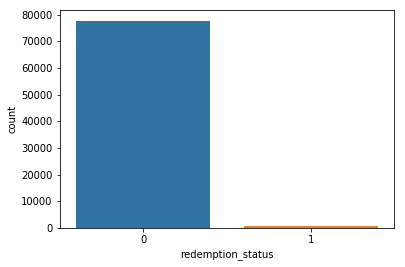

In [5]:
train.isna().sum()
sns.countplot(x='redemption_status', data=train)

Highly skewed towards **redemption_status = 0**. Positive class is just **0.9%**.

In [6]:
train.shape

(78369, 5)

In [7]:
len(train.loc[train['redemption_status']==1])

729

In [8]:
test = pd.read_csv('./test_QyjYwdj.csv')
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [9]:
print('Test data shape:', test.shape)
test.isna().sum()

Test data shape: (50226, 4)


id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64

## Merging train and test set

In [10]:
df_train = train.append(test, ignore_index=True)
df_train.shape

(128595, 5)

In [11]:
camp_data = pd.read_csv('./train_AUpWtIz/campaign_data.csv')
camp_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [12]:
coupon_item_map = pd.read_csv('./train_AUpWtIz/coupon_item_mapping.csv')
coupon_item_map.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [13]:
print(coupon_item_map.shape)
len(set(coupon_item_map['coupon_id']))

(92663, 2)


1116

In [14]:
item_data = pd.read_csv('./train_AUpWtIz/item_data.csv')
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [15]:
df_train = df_train.merge(camp_data, on='campaign_id', how='left')

In [16]:
df_train.head()

,campaign_id,coupon_id,customer_id,id,redemption_status,campaign_type,start_date,end_date
0,13,27,1053,1,0.0,X,19/05/13,05/07/13
1,13,116,48,2,0.0,X,19/05/13,05/07/13
2,9,635,205,6,0.0,Y,11/03/13,12/04/13
3,13,644,1050,7,0.0,X,19/05/13,05/07/13
4,8,1017,1489,9,0.0,X,16/02/13,05/04/13


In [17]:
df_train.shape

(128595, 8)

In [18]:
start_date_df = pd.to_datetime(df_train['start_date'])

In [19]:
df_train['start_year'] = start_date_df.dt.year
df_train['start_month'] = start_date_df.dt.month
df_train['start_day'] = start_date_df.dt.day

In [20]:
end_date_df = pd.to_datetime(df_train['end_date'])

df_train['end_year'] = end_date_df.dt.year
df_train['end_month'] = end_date_df.dt.month
df_train['end_day'] = end_date_df.dt.day

In [21]:
#df_train = df_train.merge(coupon_item_map, on='coupon_id', how='left')
#df_train = df_train.merge(item_data, on='item_id', how='left')

In [21]:
df_train.head()

,campaign_id,coupon_id,customer_id,id,redemption_status,campaign_type,start_date,end_date,start_year,start_month,start_day,end_year,end_month,end_day
0,13,27,1053,1,0.0,X,19/05/13,05/07/13,2013,5,19,2013,5,7
1,13,116,48,2,0.0,X,19/05/13,05/07/13,2013,5,19,2013,5,7
2,9,635,205,6,0.0,Y,11/03/13,12/04/13,2013,11,3,2013,12,4
3,13,644,1050,7,0.0,X,19/05/13,05/07/13,2013,5,19,2013,5,7
4,8,1017,1489,9,0.0,X,16/02/13,05/04/13,2013,2,16,2013,5,4


In [22]:
df_train.isna().sum()

campaign_id              0
coupon_id                0
customer_id              0
id                       0
redemption_status    50226
campaign_type            0
start_date               0
end_date                 0
start_year               0
start_month              0
start_day                0
end_year                 0
end_month                0
end_day                  0
dtype: int64

## Customer Demographics

In [23]:
cust_demographs = pd.read_csv('./train_AUpWtIz/customer_demographics.csv')
cust_demographs.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [24]:
cust_demographs.isna().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [25]:
cust_demographs.shape

(760, 7)

In [26]:
set(cust_demographs['marital_status'])

{'Married', 'Single', nan}

In [27]:
cust_demographs['marital_status'].value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [28]:
cust_demographs['no_of_children'].value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [29]:
cust_demographs['income_bracket'].value_counts()

5     187
4     165
6      88
3      70
2      68
1      59
8      37
7      32
9      29
12     10
10     10
11      5
Name: income_bracket, dtype: int64

In [30]:
cust_demographs['family_size'].value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [31]:
cust_demographs['no_of_children'] = cust_demographs['no_of_children'].fillna('0')

In [32]:
cust_demographs.dtypes

customer_id        int64
age_range         object
marital_status    object
rented             int64
family_size       object
no_of_children    object
income_bracket     int64
dtype: object

In [33]:
def fill_marital_status(marital_status, num_child):
    if not pd.isnull(marital_status):
        return marital_status
    elif num_child != '0':
        return 'Married'
    else:
        return 'Single'

In [34]:
cust_demographs['marital_status'] = cust_demographs.apply(lambda x: fill_marital_status(x['marital_status'], x['no_of_children']), axis=1)


In [35]:
cust_demographs.shape

(760, 7)

In [36]:
print(df_train.shape)
df_train.isna().sum()

(128595, 14)


campaign_id              0
coupon_id                0
customer_id              0
id                       0
redemption_status    50226
campaign_type            0
start_date               0
end_date                 0
start_year               0
start_month              0
start_day                0
end_year                 0
end_month                0
end_day                  0
dtype: int64

In [37]:
print(len(set(df_train['customer_id'])))
print(len(set(cust_demographs['customer_id'])))

1582
760


In [38]:
cust_demographs['no_of_children'] = cust_demographs['no_of_children'].replace('3+', 3).astype(float)
cust_demographs['family_size'] = cust_demographs['family_size'].replace('5+', 3).astype(float)

In [39]:
cust_demographs['marital_status'] = pd.Series(cust_demographs['marital_status'].factorize()[0]).replace(-1, np.nan)
cust_demographs['age_range'] = pd.Series(cust_demographs['age_range'].factorize()[0]).replace(-1, np.nan)

In [40]:
rented_mean = cust_demographs.groupby("customer_id")['rented'].mean().to_dict()
df_train['rented_mean'] = df_train['customer_id'].map(rented_mean)

income_bracket_sum = cust_demographs.groupby("customer_id")['income_bracket'].sum().to_dict()
df_train['income_bracket_sum'] = df_train['customer_id'].map(income_bracket_sum)
# age_range
age_range_mean = cust_demographs.groupby("customer_id")['age_range'].mean().to_dict()
df_train['age_range_mean'] = df_train['customer_id'].map(age_range_mean)
# family_size
family_size_mean = cust_demographs.groupby("customer_id")['family_size'].mean().to_dict()
df_train['family_size_mean'] = df_train['customer_id'].map(family_size_mean)
# no_of_children
no_of_children_mean = cust_demographs.groupby("customer_id")['no_of_children'].mean().to_dict()
df_train['no_of_children_mean'] = df_train['customer_id'].map(no_of_children_mean)
no_of_children_count = cust_demographs.groupby("customer_id")['no_of_children'].count().to_dict()
df_train['no_of_children_count'] = df_train['customer_id'].map(no_of_children_count)
# marital_status
marital_status_count = cust_demographs.groupby("customer_id")['marital_status'].count().to_dict()
df_train['marital_status_count'] = df_train['customer_id'].map(marital_status_count)

## Customer Transaction Data

In [42]:
cust_transact_data = pd.read_csv('./train_AUpWtIz/customer_transaction_data.csv')

In [43]:
cust_transact_data.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [44]:
cust_transact_data = cust_transact_data.merge(item_data, on='item_id', how='left')

## Aggregate customer transaction data based on customer_id

In [52]:
#cust_transact_data = pd.get_dummies(cust_transact_data, columns=['brand_type','category'], drop_first=False)

In [45]:
cust_transact_data.columns

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'brand', 'brand_type', 'category'],
      dtype='object')

In [47]:
agg_func = {
    'item_id': ['count'],
    'quantity': ['mean'],
    'selling_price': ['mean', 'min', 'max', 'sum'],
    'other_discount': ['mean'],
    'coupon_discount': ['mean']
    #'brand': ['count'],
#     'brand_type_Established': ['sum', 'min', 'max', 'mean', 'count'],
#     'brand_type_Local': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Alcohol': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Bakery': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Dairy, Juices & Snacks': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Flowers & Plants': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Fuel': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Garden': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Grocery': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Meat': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Miscellaneous': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Natural Products': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Packaged Meat': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Pharmaceutical': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Prepared Food': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Restauarant': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Salads': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Seafood': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Skin & Hair Care': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Travel': ['sum', 'min', 'max', 'mean', 'count'],
#     'category_Vegetables (cut)': ['sum', 'min', 'max', 'mean', 'count']
}

In [48]:
cust_transact_data1 = cust_transact_data.groupby('customer_id').agg(agg_func)

In [49]:
cust_transact_data1.head()

item_id    quantity selling_price                             \
              count        mean          mean    min      max        sum   
customer_id                                                                
1              1048    1.170802     94.001842  12.11   445.25   98513.93   
2               419    1.131265    102.864033  14.25   640.80   43100.03   
3               705   11.578723    103.617404   8.90   862.00   73050.27   
4               220    1.272727    154.423727  14.25  1330.05   33973.22   
5               792  117.869949    130.827146  12.11  1485.35  103615.10   

            other_discount coupon_discount  
                      mean            mean  
customer_id                                 
1               -16.250382       -2.019876  
2               -16.830430       -0.595084  
3               -22.714227       -3.091546  
4               -13.305409       -0.404773  
5               -13.657917       -0.114684

In [50]:
cust_transact_data1.columns = ['J_' + '_'.join(col).strip() for col in cust_transact_data1.columns.values]
cust_transact_data1.reset_index(inplace=True)
cust_transact_data1.head()

,customer_id,J_item_id_count,J_quantity_mean,J_selling_price_mean,J_selling_price_min,J_selling_price_max,J_selling_price_sum,J_other_discount_mean,J_coupon_discount_mean
0,1,1048,1.170802,94.001842,12.11,445.25,98513.93,-16.250382,-2.019876
1,2,419,1.131265,102.864033,14.25,640.80,43100.03,-16.830430,-0.595084
2,3,705,11.578723,103.617404,8.90,862.00,73050.27,-22.714227,-3.091546
3,4,220,1.272727,154.423727,14.25,1330.05,33973.22,-13.305409,-0.404773
4,5,792,117.869949,130.827146,12.11,1485.35,103615.10,-13.657917,-0.114684


In [51]:
cust_transact_data1.shape

(1582, 9)

In [52]:
df_train.head()

,campaign_id,coupon_id,customer_id,id,redemption_status,campaign_type,start_date,end_date,start_year,start_month,...,end_year,end_month,end_day,rented_mean,income_bracket_sum,age_range_mean,family_size_mean,no_of_children_mean,no_of_children_count,marital_status_count
0,13,27,1053,1,0.0,X,19/05/13,05/07/13,2013,5,...,2013,5,7,0.0,5.0,1.0,1.0,0.0,1.0,1.0
1,13,116,48,2,0.0,X,19/05/13,05/07/13,2013,5,...,2013,5,7,0.0,3.0,3.0,2.0,0.0,1.0,1.0
2,9,635,205,6,0.0,Y,11/03/13,12/04/13,2013,11,...,2013,12,4,0.0,7.0,1.0,2.0,0.0,1.0,1.0
3,13,644,1050,7,0.0,X,19/05/13,05/07/13,2013,5,...,2013,5,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1017,1489,9,0.0,X,16/02/13,05/04/13,2013,2,...,2013,5,4,0.0,3.0,1.0,2.0,0.0,1.0,1.0


In [53]:
df_train.drop(['id', 'start_date', 'end_date'], axis=1, inplace=True)

In [54]:
df_train.shape

(128595, 18)

In [55]:
df_train = df_train.merge(cust_transact_data1, on='customer_id', how='left')

In [56]:
df_train.shape

(128595, 26)

## Aggregate item data based on item_id corresponding to the coupon id

In [57]:
coupon_item_map = coupon_item_map.merge(item_data, how = 'left', on = 'item_id')
coupon_item_map['brand_type'] = pd.Series(coupon_item_map['brand_type'].factorize()[0]).replace(-1, np.nan)
coupon_item_map['category'] = pd.Series(coupon_item_map['category'].factorize()[0]).replace(-1, np.nan)

category = coupon_item_map.groupby("coupon_id")['category'].mean().to_dict()
df_train['category_mean'] = df_train['coupon_id'].map(category)
category = coupon_item_map.groupby("coupon_id")['category'].count().to_dict()
df_train['category_count'] = df_train['coupon_id'].map(category)
category = coupon_item_map.groupby("coupon_id")['category'].nunique().to_dict()
df_train['category_nunique'] = df_train['coupon_id'].map(category)
category = coupon_item_map.groupby("coupon_id")['category'].max().to_dict()
df_train['category_max'] = df_train['coupon_id'].map(category)
category = coupon_item_map.groupby("coupon_id")['category'].min().to_dict()
df_train['category_min'] = df_train['coupon_id'].map(category)

brand_mean = coupon_item_map.groupby("coupon_id")['brand'].mean().to_dict()
df_train['brand_mean'] = df_train['coupon_id'].map(brand_mean)
brand_mean = coupon_item_map.groupby("coupon_id")['brand'].count().to_dict()
df_train['brand_count'] = df_train['coupon_id'].map(brand_mean)
brand_mean = coupon_item_map.groupby("coupon_id")['brand'].min().to_dict()
df_train['brand_min'] = df_train['coupon_id'].map(brand_mean)
brand_mean = coupon_item_map.groupby("coupon_id")['brand'].max().to_dict()
df_train['brand_max'] = df_train['coupon_id'].map(brand_mean)
brand_mean = coupon_item_map.groupby("coupon_id")['brand'].nunique().to_dict()
df_train['brand_nunique'] = df_train['coupon_id'].map(brand_mean)

In [58]:
df_train.head()

,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_year,start_month,start_day,end_year,end_month,...,category_mean,category_count,category_nunique,category_max,category_min,brand_mean,brand_count,brand_min,brand_max,brand_nunique
0,13,27,1053,0.0,X,2013,5,19,2013,5,...,0.0,125,1,0,0,1364.128,125,1105,1636,2
1,13,116,48,0.0,X,2013,5,19,2013,5,...,0.0,3,1,0,0,56.000,3,56,56,1
2,9,635,205,0.0,Y,2013,11,3,2013,12,...,3.0,67,1,3,3,560.000,67,560,560,1
3,13,644,1050,0.0,X,2013,5,19,2013,5,...,0.0,4,1,0,0,611.000,4,611,611,1
4,8,1017,1489,0.0,X,2013,2,16,2013,5,...,0.0,32,1,0,0,1558.000,32,1558,1558,1


## Final Training set

In [59]:
df_train.shape

(128595, 36)

## Label Encoding

In [60]:
df_train.dtypes

campaign_id                 int64
coupon_id                   int64
customer_id                 int64
redemption_status         float64
campaign_type              object
start_year                  int64
start_month                 int64
start_day                   int64
end_year                    int64
end_month                   int64
end_day                     int64
rented_mean               float64
income_bracket_sum        float64
age_range_mean            float64
family_size_mean          float64
no_of_children_mean       float64
no_of_children_count      float64
marital_status_count      float64
J_item_id_count             int64
J_quantity_mean           float64
J_selling_price_mean      float64
J_selling_price_min       float64
J_selling_price_max       float64
J_selling_price_sum       float64
J_other_discount_mean     float64
J_coupon_discount_mean    float64
category_mean             float64
category_count              int64
category_nunique            int64
category_max  

In [78]:
lb_encoder = LabelEncoder()
df_train['campaign_type'] = lb_encoder.fit_transform(df_train['campaign_type'])

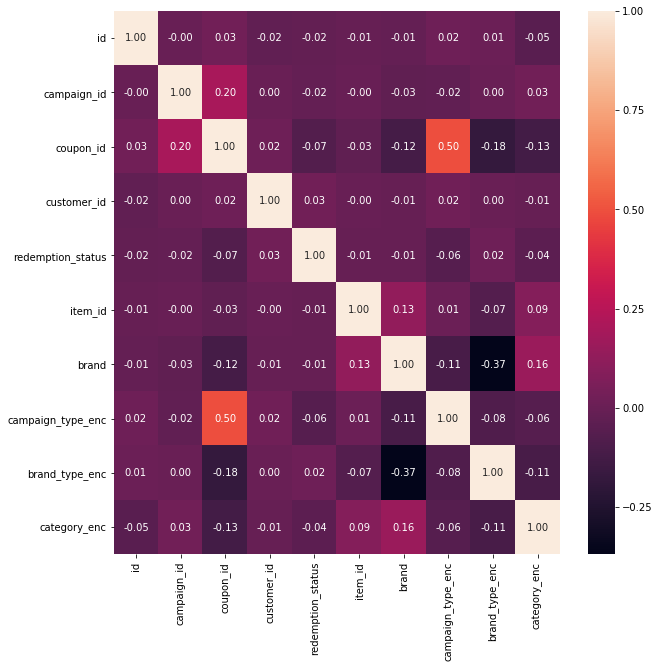

In [133]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr(), fmt='.2f', annot=True)

In [79]:
train = df_train[df_train['redemption_status'].isnull() != True]
test = df_train[df_train['redemption_status'].isnull() == True]
test.drop(['redemption_status'], axis=1, inplace=True)

/Users/Technocrat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
print('Train set shape', train.shape)
print('Test set shape', test.shape)

Train set shape (78369, 36)
Test set shape (50226, 35)


## Modeling

In [81]:
X = train.drop(labels=['redemption_status'], axis=1)
y = train['redemption_status']

In [82]:
#sc = StandardScaler()
#X = sc.fit_transform(X)
X.dtypes

campaign_id                 int64
coupon_id                   int64
customer_id                 int64
campaign_type               int64
start_year                  int64
start_month                 int64
start_day                   int64
end_year                    int64
end_month                   int64
end_day                     int64
rented_mean               float64
income_bracket_sum        float64
age_range_mean            float64
family_size_mean          float64
no_of_children_mean       float64
no_of_children_count      float64
marital_status_count      float64
J_item_id_count             int64
J_quantity_mean           float64
J_selling_price_mean      float64
J_selling_price_min       float64
J_selling_price_max       float64
J_selling_price_sum       float64
J_other_discount_mean     float64
J_coupon_discount_mean    float64
category_mean             float64
category_count              int64
category_nunique            int64
category_max                int64
category_min  

In [83]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Using 10-Fold cross-validation with CatBoost Classifier

In [104]:
def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None, label='model', n_folds=5):
    kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        #feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results


def runCAT(train_X, train_y, test_X, test_y, test_X2, params):
    # Pool the data and specify the categorical feature indices
    print('Pool Data')
    _train = Pool(train_X, label=train_y)
    _valid = Pool(test_X, label=test_y)    
    print('Train CAT')
    model = CatBoostClassifier(**params)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=1000,
                          plot=False)
    feature_im = fit_model.feature_importances_
    print('Predict 1/2')
    pred_test_y = fit_model.predict_proba(test_X)[:, 1]
    
    print('Predict 2/2')
    pred_test_y2 = fit_model.predict_proba(test_X2)[:, 1]
    return pred_test_y, pred_test_y2, feature_im

In [114]:
#clf = RandomForestClassifier(class_weight={0:1, 1:2})
#clf = RandomForestRegressor()
#clf = LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, n_estimators=100)  #best 0.78777 (LB)
#clf = xgb.XGBRegressor(max_depth=5)
#clf = CatBoostClassifier()  # 0.78404 (LB)
#clf = LogisticRegression()

clf = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100)
#clf = clf.fit(X_train, y_train)
clf = clf.fit(X, y)

In [112]:
pred_cv = clf.predict_proba(X_cv)

In [113]:
roc_auc_score(y_cv, pred_cv[:, 1])

0.9393847967083765

## Working on real test set

In [105]:
X_test = test

In [106]:
print(X_test.shape)

(50226, 35)


In [107]:
# Use some baseline parameters
cat_params = {'loss_function': 'CrossEntropy', 
              'eval_metric': "AUC",
              'learning_rate': 0.01,
              'iterations': 10000,
              'random_seed': 42,
              'od_type': "Iter",
              'early_stopping_rounds': 150,
             }

n_folds = 10
results = run_cv_model(X.fillna(0), X_test.fillna(0), y, runCAT, cat_params, roc_auc_score, 'cat', n_folds=n_folds)

-------------------------------------------
Started cat fold 1/10
Pool Data
Train CAT
0:	test: 0.8708343	best: 0.8708343 (0)	total: 38.5ms	remaining: 6m 24s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8954888385
bestIteration = 14

Shrink model to first 15 iterations.
Predict 1/2
Predict 2/2
cat cv score 1: 0.8954888385453057 

-------------------------------------------
Started cat fold 2/10
Pool Data
Train CAT
0:	test: 0.8232499	best: 0.8232499 (0)	total: 40.8ms	remaining: 6m 47s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.8609440833
bestIteration = 5

Shrink model to first 6 iterations.
Predict 1/2
Predict 2/2
cat cv score 2: 0.8609440833350976 

-------------------------------------------
Started cat fold 3/10
Pool Data
Train CAT
0:	test: 0.8315760	best: 0.8315760 (0)	total: 45.5ms	remaining: 7m 34s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.89182599
bestIteration = 6

Shrink model to first 7 iterations.
Pr

In [118]:
#pred_test = clf.predict_proba(X_test)

In [108]:
#pred_test[:, 1]

In [109]:
submission = pd.read_csv('sample_submission_Byiv0dS.csv')
submission.head()

,id,redemption_status
0,3,0
1,4,0
2,5,0
3,8,0
4,10,0


In [110]:
tmp = dict(zip(submission.id.values, results['test']))
answer1 = pd.DataFrame()
answer1['id'] = submission.id.values
answer1['redemption_status'] = answer1['id'].map(tmp)
answer1.to_csv('submission3.csv', index = None)

In [121]:
#submission['redemption_status'] = pred_test[:, 1]

In [103]:
#submission.head()

In [123]:
#submission.to_csv('./submission.csv', index=False)